**TIRE BINARY CLASSIFICATION**
# New Section



*   List item
*   List item





# **IMPORTING THE LIBRARY**

In [182]:
#Importing library
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL.Image as image
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# **USING DRIVE FOR THE DATASETS**

In [183]:
#mount the g drive for the dataset into colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **SPLIT THE DATASET INTO TRAIN AND TESTS**




In [213]:
#the dataset has been manually divided into 80:20 for train and test in google drive
train_dataset_path = ("/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH//256/train")
validation_dataset_path = ("/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/256/test")

# **LOAD THE EXAMPLE OF THE DATA THAT AMOUNTED TO DRIVE**

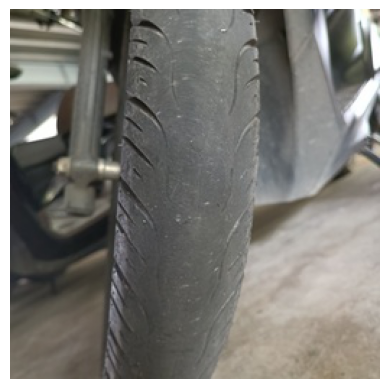

no image


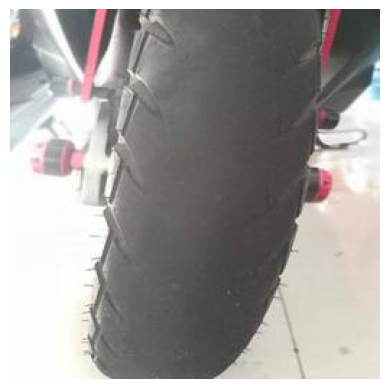

no image


In [214]:
#load the image for showing the example

import os
from PIL import Image
import random
import glob


def read_random_image(folder_path):
    # taking the path of image file
    image_files = glob.glob(os.path.join(folder_path, "*.jpg")) + glob.glob(os.path.join(folder_path, "*.jpeg"))

    if len(image_files) == 0:
        print("no image")
        return None

    # choosing the file by randomize
    random_image_path = random.choice(image_files)
    image = Image.open(random_image_path)

    # showing the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    return image

# defining the path
bad_tires_in_training = "/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/256/train/kualitas buruk"
good_tires_in_training = "/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/256/train/kualitas baik"
bad_tires_in_validation = "/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/256/test/kualitas buruk"
good_tires_in_validation = "/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/256/test/kualitas baik"

# read by randomize the file from path
random_image = read_random_image(bad_tires_in_training)
random_image = read_random_image(good_tires_in_training)
random_image = read_random_image(bad_tires_in_validation)
random_image = read_random_image(good_tires_in_validation)

## **DATA PREPROCESSING**

In [215]:
# Define image dimensions and batch size
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32

In [216]:
#defining the data generators for training set
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  rotation_range = 40,
                                  zoom_range=0.28,
                                  shear_range=0.3,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size= (IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   color_mode ='rgb',
                                                   class_mode='binary',
                                                   shuffle=True)

Found 157 images belonging to 2 classes.


In [217]:
#defining the data generators for validatioin set
validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        )
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             color_mode ='rgb',
                                                             class_mode='binary',
                                                             shuffle=True)

Found 34 images belonging to 2 classes.


In [218]:
#show the label

labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label class from data train and test as well\n")
for key, value in labels.items():
    print(f"{key} : {value}")

#the train datasaet label as well as the dataset label

Label class from data train and test as well

0 : kualitas bagus
1 : kualitas buruk


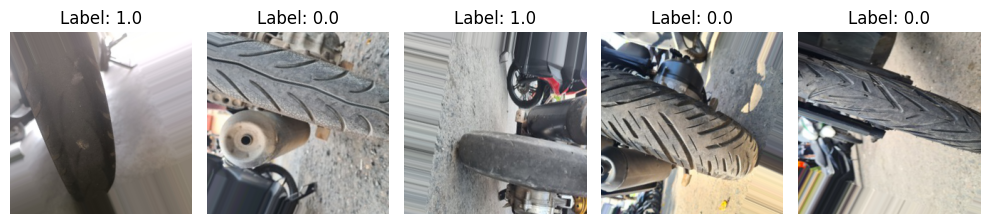

In [219]:
#showing the sample of image from ImageGenerator

import random

num_images = 5
total_batches = len(train_generator)

if num_images > total_batches:
    num_images = total_batches

# get the images randomly
random_indices = random.sample(range(total_batches), num_images)

# plot the images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    if i < num_images:
        index = random_indices[i]
        batch_images, batch_labels = train_generator[index]
        ax.imshow(batch_images[0])
        ax.set_title(f"Label: {batch_labels[0]}")
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()



In [220]:
sample_train_images, _ = next(train_generator)
print(sample_train_images.shape)

(32, 256, 256, 3)


In [221]:
sample_valid_images, _ = next(validation_generator)
print(sample_valid_images.shape)

(32, 256, 256, 3)


# MODEL BUILD

In [194]:
#Install the keras tuner to gain best model from random search 
pip install keras-tuner


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 8.8 MB/s eta 0:00:00


In [233]:
#defining the model architecture
from tensorflow.keras import regularizers



#This is the model that we build manually and test it by many combination of structure
model = Sequential([

tf.keras.layers.Conv2D(16, (5,5), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


#This is the model that we try after get the best result from hypertuning from keras
"""
model = Sequential([
    tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=80, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(filters=48, kernel_size=(5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])"""

#This is the model we try with some regulizer input
"""model = Sequential([
    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3),
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                           kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu',
                          kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])"""


"model = Sequential([\n    tf.keras.layers.Conv2D(16, (5, 5), activation='relu', input_shape=(256, 256, 3),\n                           kernel_regularizer=regularizers.l2(0.01)),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',\n                           kernel_regularizer=regularizers.l2(0.01)),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',\n                           kernel_regularizer=regularizers.l2(0.01)),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',\n                           kernel_regularizer=regularizers.l2(0.01)),\n    tf.keras.layers.MaxPooling2D(2, 2),\n    tf.keras.layers.Flatten(),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(1024, activation='relu',\n                          kernel_regularizer=regularizers.l2(0.01)),\n    tf.keras.layers.Dense(1, activation='sigmoid')\n])"

In [234]:
#using adam optimizer
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay = 1e-4,
                 beta_1=0.8,
                 beta_2=0.999,
                 amsgrad=True)

In [224]:
#defining the callback ()

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

"""class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        train_accuracy = logs.get("accuracy")
        if val_accuracy > self.threshold and train_accuracy > self.threshold:
            self.model.stop_training = True

callbacks = MyThresholdCallback(threshold=0.92)"""


'class MyThresholdCallback(tf.keras.callbacks.Callback):\n    def __init__(self, threshold):\n        super().__init__()\n        self.threshold = threshold\n\n    def on_epoch_end(self, epoch, logs=None):\n        val_accuracy = logs.get("val_accuracy")\n        train_accuracy = logs.get("accuracy")\n        if val_accuracy > self.threshold and train_accuracy > self.threshold:\n            self.model.stop_training = True\n\ncallbacks = MyThresholdCallback(threshold=0.92)'

In [235]:
#compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 252, 252, 16)      1216      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 126, 126, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 124, 124, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      

In [202]:
"""import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

# Define the hypermodel
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Conv2D(hp.Int('filters_1', min_value=16, max_value=128, step=16), (hp.Choice('kernel_size_1', values=[3, 5]), hp.Choice('kernel_size_1', values=[3, 5])), activation='relu', input_shape=(256, 256, 3)))
        model.add(layers.MaxPooling2D(2, 2))
        model.add(layers.Conv2D(hp.Int('filters_2', min_value=16, max_value=128, step=16), (hp.Choice('kernel_size_2', values=[3, 5]), hp.Choice('kernel_size_2', values=[3, 5])), activation='relu'))
        model.add(layers.MaxPooling2D(2, 2))
        model.add(layers.Conv2D(hp.Int('filters_3', min_value=16, max_value=128, step=16), (hp.Choice('kernel_size_3', values=[3, 5]), hp.Choice('kernel_size_3', values=[3, 5])), activation='relu'))
        model.add(layers.MaxPooling2D(2, 2))
        model.add(layers.Conv2D(hp.Int('filters_4', min_value=16, max_value=128, step=16), (hp.Choice('kernel_size_4', values=[3, 5]), hp.Choice('kernel_size_4', values=[3, 5])), activation='relu'))
        model.add(layers.MaxPooling2D(2, 2))
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.2))
        model.add(layers.Dense(1024, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

# Define the hyperparameters and tuner
hypermodel = MyHyperModel()
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    directory='my_tuner_dir',
    project_name='my_tuner_project'
)

# Perform the hyperparameter search
tuner.search(train_generator, epochs=10, validation_data=validation_generator)

# Retrieve the best model
best_model = tuner.get_best_models(1)[0]

# Fit the best model to the training data
best_model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(test_generator)

# Print the test accuracy
print('Test Accuracy:', test_accuracy)"""


Trial 10 Complete [00h 00m 46s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.7647058963775635
Total elapsed time: 00h 07m 12s
Epoch 1/10
5/5 [==============================] - 7s 787ms/step - loss: 0.7062 - accuracy: 0.5287 - val_loss: 0.6742 - val_accuracy: 0.6765
Epoch 2/10
5/5 [==============================] - 3s 563ms/step - loss: 0.6802 - accuracy: 0.5669 - val_loss: 0.6809 - val_accuracy: 0.4706
Epoch 3/10
5/5 [==============================] - 3s 571ms/step - loss: 0.6835 - accuracy: 0.5096 - val_loss: 0.6772 - val_accuracy: 0.5000
Epoch 4/10
5/5 [==============================] - 3s 718ms/step - loss: 0.6905 - accuracy: 0.5796 - val_loss: 0.6702 - val_accuracy: 0.6765
Epoch 5/10
5/5 [==============================] - 4s 712ms/step - loss: 0.6844 - accuracy: 0.5605 - val_loss: 0.6679 - val_accuracy: 0.6765
Epoch 6/10
5/5 [==============================] - 3s 559ms/step - loss: 0.6702 - accuracy: 0.6115 - val_loss: 0.6548 - val_accuracy: 0.5000
Epoch 7/10
5/5 [================

In [211]:
print(tuner.results_summary())


Results summary
Results in my_tuner_dir/my_tuner_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
filters_1: 128
kernel_size_1: 5
filters_2: 80
kernel_size_2: 3
filters_3: 16
kernel_size_3: 3
filters_4: 48
kernel_size_4: 5
Score: 0.7647058963775635

Trial 03 summary
Hyperparameters:
filters_1: 112
kernel_size_1: 5
filters_2: 80
kernel_size_2: 3
filters_3: 96
kernel_size_3: 3
filters_4: 128
kernel_size_4: 5
Score: 0.7058823704719543

Trial 07 summary
Hyperparameters:
filters_1: 64
kernel_size_1: 5
filters_2: 80
kernel_size_2: 3
filters_3: 96
kernel_size_3: 5
filters_4: 64
kernel_size_4: 5
Score: 0.7058823704719543

Trial 08 summary
Hyperparameters:
filters_1: 48
kernel_size_1: 3
filters_2: 32
kernel_size_2: 5
filters_3: 48
kernel_size_3: 3
filters_4: 96
kernel_size_4: 5
Score: 0.7058823704719543

Trial 02 summary
Hyperparameters:
filters_1: 128
kernel_size_1: 5
filters_2: 48
kernel_size_2: 3
filters_3: 16
kernel_size_3: 3


In [236]:
history = model.fit(train_generator, epochs=60, validation_data=validation_generator,
                       verbose=2,
                       
                       )

Epoch 1/60
5/5 - 4s - loss: 1.1291 - accuracy: 0.5414 - val_loss: 0.6867 - val_accuracy: 0.5000 - 4s/epoch - 737ms/step
Epoch 2/60
5/5 - 3s - loss: 0.6985 - accuracy: 0.4586 - val_loss: 0.6870 - val_accuracy: 0.5000 - 3s/epoch - 552ms/step
Epoch 3/60
5/5 - 3s - loss: 0.6848 - accuracy: 0.5032 - val_loss: 0.6792 - val_accuracy: 0.5294 - 3s/epoch - 690ms/step
Epoch 4/60
5/5 - 3s - loss: 0.6787 - accuracy: 0.6178 - val_loss: 0.6563 - val_accuracy: 0.7647 - 3s/epoch - 661ms/step
Epoch 5/60
5/5 - 3s - loss: 0.6417 - accuracy: 0.7006 - val_loss: 0.9334 - val_accuracy: 0.5000 - 3s/epoch - 537ms/step
Epoch 6/60
5/5 - 3s - loss: 0.6904 - accuracy: 0.5987 - val_loss: 0.6407 - val_accuracy: 0.5882 - 3s/epoch - 531ms/step
Epoch 7/60
5/5 - 3s - loss: 0.6717 - accuracy: 0.5924 - val_loss: 0.6255 - val_accuracy: 0.5882 - 3s/epoch - 587ms/step
Epoch 8/60
5/5 - 3s - loss: 0.5957 - accuracy: 0.6688 - val_loss: 0.6473 - val_accuracy: 0.5294 - 3s/epoch - 539ms/step
Epoch 9/60
5/5 - 3s - loss: 0.5918 - acc

# PLOTTING THE RESULT FROM EPOCH OF THE TRAINING

In [237]:
#Define the accuracy and loss from the train and validation
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']



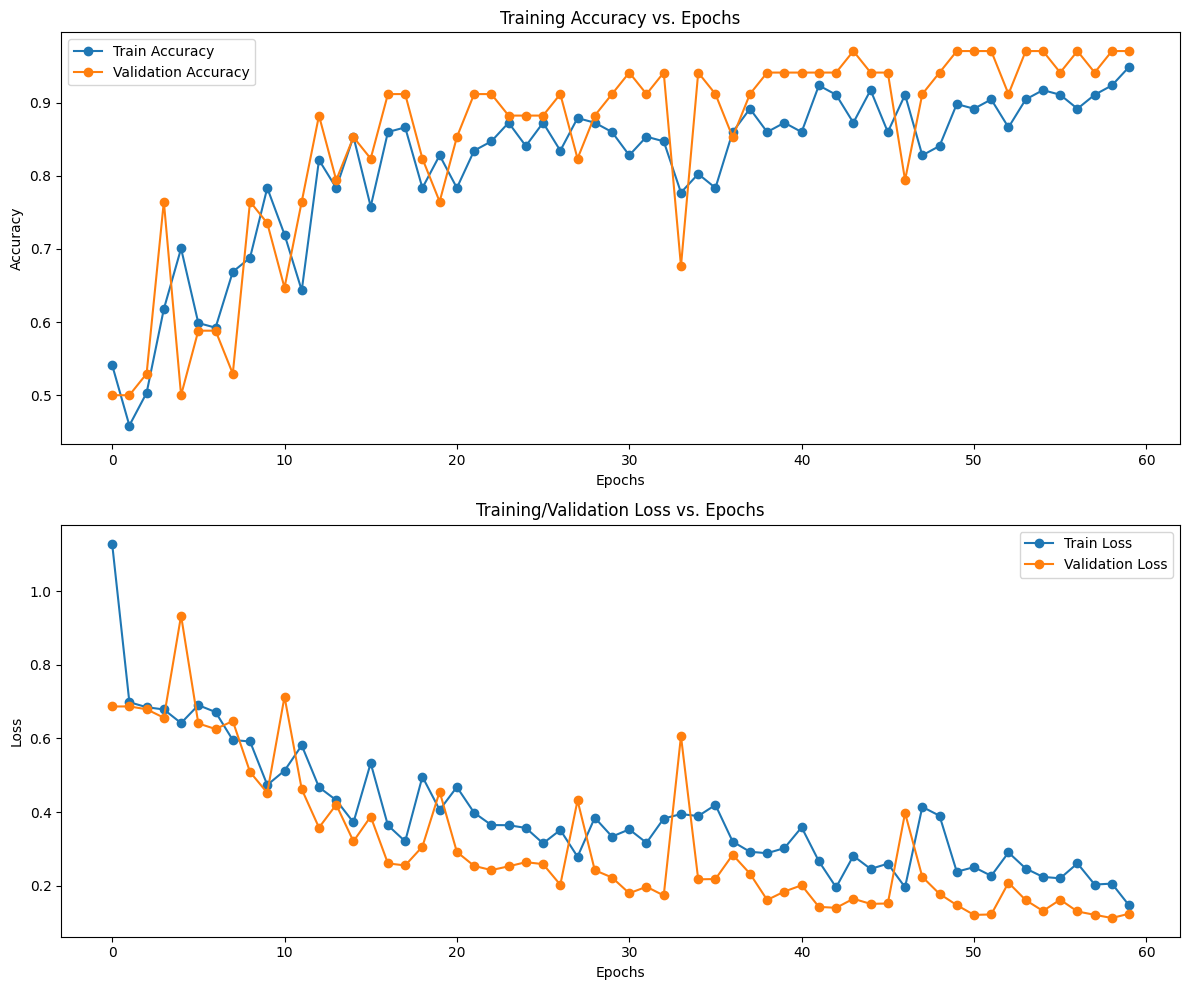

In [238]:
#Plotting the result
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')



plt.tight_layout()
plt.show()

# TESTING THE MODEL

In [239]:
#Import the test data from drive 
test_dataset_path = ("/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/testtt")

In [240]:
#preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset_path,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='binary')

Found 12 images belonging to 2 classes.


In [241]:
#Define the prediction from the model
predictions = model.predict(test_generator)

1/1 [==============================] - 1s 577ms/step


In [ ]:
#Plot the result from data test path
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(10, 8))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20, color = 'red')
plt.show()

In [242]:
#testing the loss and accuracy from the data test

test_loss, test_accuracy = model.evaluate(test_generator, batch_size=BATCH_SIZE)

1/1 [==============================] - 1s 519ms/step - loss: 0.2221 - accuracy: 0.9167


In [181]:

from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(256, 256))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images, batch_size=32)

    print(fn)
    if classes[0, 0] == 1.0:
        print('Kualitas buruk')
    else:
        print('Kualitas baik')


KeyboardInterrupt: ignored

# SAVED THE MODEL FOR DEPLOYMENT

In [ ]:
from tensorflow.keras.models import load_model
import os


In [ ]:
model.save(os.path.join('drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/file model', 'Tirebinary.h5'))

In [ ]:
model = keras.models.load_model('drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/file model/Tirebinary.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
with open('drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/file model/Tirebinary.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
model_json = model.to_json()

In [ ]:
with open('drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/file model/Tirebinary.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
model.save('/content/drive/MyDrive/CAPSTONE BANGKIT PROJECT BISMILLAH/file model/saved_model')